<a href="https://colab.research.google.com/github/KleberBarcarollo/scanner/blob/main/projeto_escaneamento_de_documentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OCR Projeto: Escaneamento de imagem

# Importando as bibliotecas

In [ ]:
import numpy as np
import cv2
import imutils
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

# Conectando com o Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Projeto_pesquisa/result

cp: missing destination file operand after '/content/drive/MyDrive/Projeto_pesquisa/result'
Try 'cp --help' for more information.


In [ ]:
def mostrar(img):
  fig = plt.gcf()
  fig.set_size_inches(20, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

# Processamentos na imagem (para transformação)

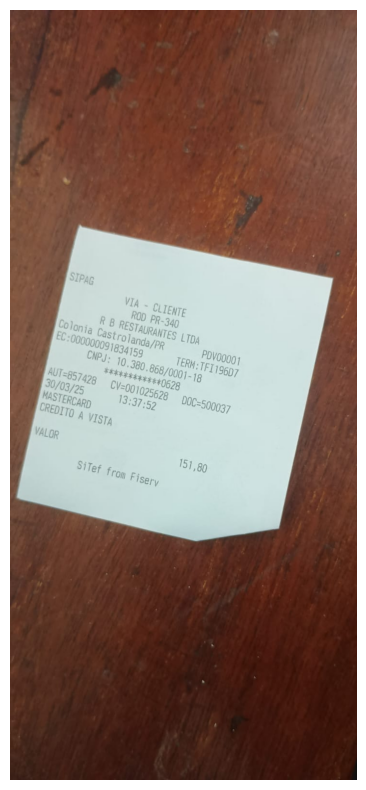

1600 720


In [ ]:
img = cv2.imread('/content/drive/MyDrive/Projeto_pesquisa/result/12.jpg')
original = img.copy()
mostrar(img)
(H, W) = img.shape[:2]
print(H, W)

## Conversão para tons de cinza (*grayscale*)

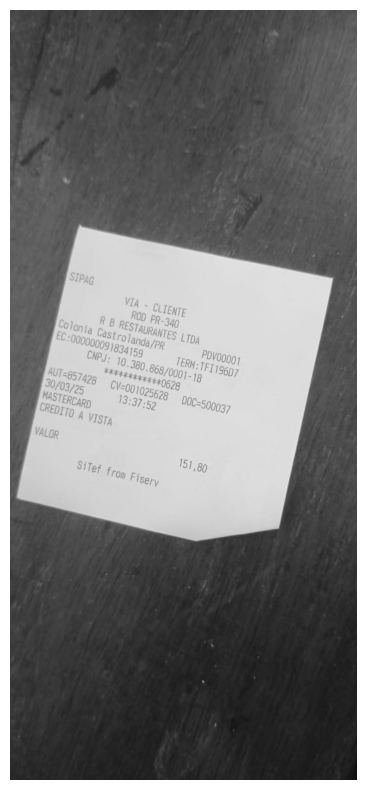

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mostrar(gray)

## Aplicação de desfoque (*Gaussian Blur*)

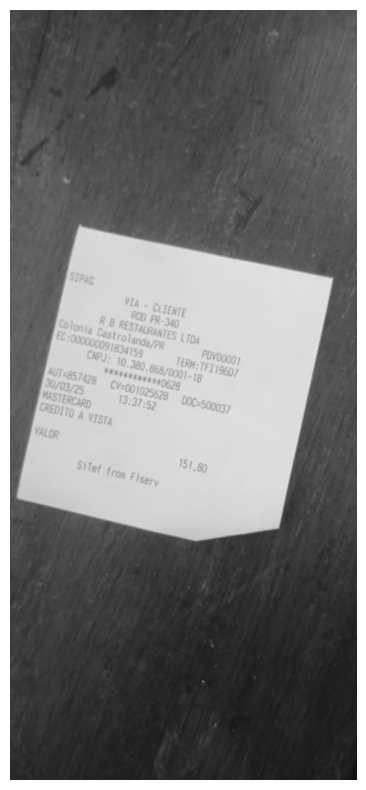

In [ ]:
blur = cv2.GaussianBlur(gray, (5, 5), 0)
mostrar(blur)

## Detecção de bordas (*Canny Edge*)

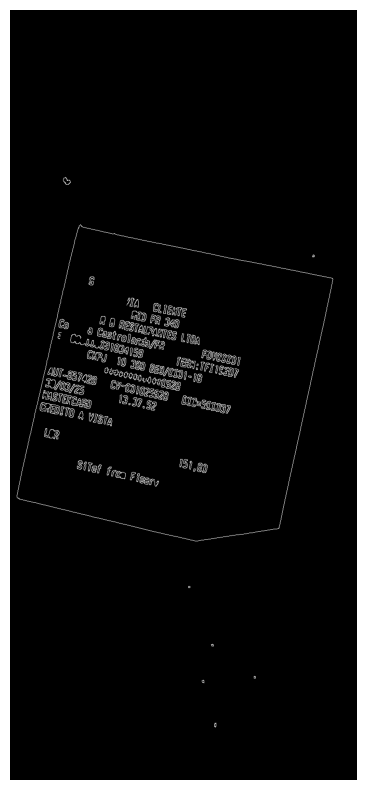

In [ ]:
edged = cv2.Canny(blur, 60, 160)
mostrar(edged)

# Detecção de contornos na imagem

In [ ]:
def encontrar_contornos(img):
  conts = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sorted(conts, key = cv2.contourArea, reverse = True)[:6]
  return conts

In [ ]:
conts = encontrar_contornos(edged.copy())

In [ ]:
conts

[array([[[ 66, 815]],
 
        [[ 64, 817]],
 
        [[ 64, 818]],
 
        [[ 63, 819]],
 
        [[ 63, 822]],
 
        [[ 62, 823]],
 
        [[ 62, 827]],
 
        [[ 61, 828]],
 
        [[ 62, 829]],
 
        [[ 62, 831]],
 
        [[ 63, 832]],
 
        [[ 64, 832]],
 
        [[ 65, 833]],
 
        [[ 68, 833]],
 
        [[ 69, 832]],
 
        [[ 70, 833]],
 
        [[ 74, 833]],
 
        [[ 74, 830]],
 
        [[ 76, 828]],
 
        [[ 77, 829]],
 
        [[ 77, 834]],
 
        [[ 78, 835]],
 
        [[ 78, 836]],
 
        [[ 80, 834]],
 
        [[ 80, 830]],
 
        [[ 79, 829]],
 
        [[ 82, 826]],
 
        [[ 82, 824]],
 
        [[ 83, 823]],
 
        [[ 83, 820]],
 
        [[ 84, 819]],
 
        [[ 85, 820]],
 
        [[ 85, 824]],
 
        [[ 84, 825]],
 
        [[ 84, 828]],
 
        [[ 83, 829]],
 
        [[ 83, 834]],
 
        [[ 82, 835]],
 
        [[ 84, 837]],
 
        [[ 86, 837]],
 
        [[ 87, 838]],
 
        [[ 91, 8

## Localizando o maior contorno

- Douglas-Peucker: http://en.wikipedia.org/wiki/Ramer-Douglas-Peucker_algorithm

In [ ]:
for c in conts:
  perimetro = cv2.arcLength(c, True)
  aproximacao = cv2.approxPolyDP(c, 0.02 * perimetro, True)
  if len(aproximacao) == 5:
    maior = aproximacao
    break

In [ ]:
maior

array([[[239, 962]],

       [[237, 974]],

       [[219, 969]],

       [[222, 958]]], dtype=int32)

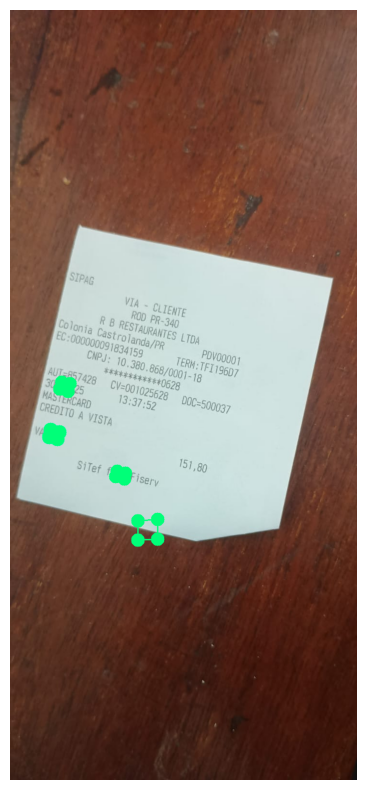

In [ ]:
cv2.drawContours(img, maior, -1, (120, 255, 0), 28)
cv2.drawContours(img, [maior], -1, (120, 255, 0), 2)
mostrar(img)

## Ordenando os pontos

Nós ja temos as 4 coordenadas x-y que correspondem aos cantos do retângulo/polígono localizado na imagem, porém esses pontos provavelmente estarão fora de uma ordem. Para fazer a transformação de perspectiva precisamos ordenar os pontos, de modo que eles fiquem em uma ordem padrão e assim seja possível aplicar a transformação.

É crucial que a ordem dos pontos do retângulo esteja consistente em todo o programa. Pois caso mude de ordem algum desses pontos a transformação não vai ficar da forma que queremos.

Nós escolhemos essa ordem:

1. **te** = topo esquerdo (superior esquerdo)
2. **td** = topo direito (superior direito)
3. **bd** = baixo direito (inferior direito)
4. **be** = baixo esquerdo (inferior esquerdo)

Preferimos deixar nessa ordem por ser um padrão mais utilizado. Você poderia se quiser mudar a ordem, deixar por exemplo `be` antes de `bd` e após `td`, só que se for fazer assim precisa manter essa ordem no restante do programa (especificamente na parte do pts2 que veremos abaixo, trocando o [W, H] por [0, H])

In [ ]:
def ordenar_pontos(pontos):
  pontos = pontos.reshape((4,2))
  pontos_novos = np.zeros((4, 1, 2), dtype=np.int32)

  add = pontos.sum(1)
  pontos_novos[0] = pontos[np.argmin(add)]
  pontos_novos[2] = pontos[np.argmax(add)]

  dif = np.diff(pontos, axis = 1)
  pontos_novos[1] = pontos[np.argmin(dif)]
  pontos_novos[3] = pontos[np.argmax(dif)]

  return pontos_novos

In [ ]:
pontos_maior = ordenar_pontos(maior)
print(pontos_maior)

[[[  22  571]]

 [[ 442  337]]

 [[ 692  810]]

 [[ 236 1037]]]


In [ ]:
maior

array([[[ 442,  337]],

       [[  22,  571]],

       [[ 236, 1037]],

       [[ 692,  810]]], dtype=int32)

## Obtenção da matriz de transformação

In [ ]:
pts1 = np.float32(pontos_maior)

In [ ]:
pts1

array([[[  22.,  571.]],

       [[ 442.,  337.]],

       [[ 692.,  810.]],

       [[ 236., 1037.]]], dtype=float32)

In [ ]:
print(H, W)

1600 720


In [ ]:
pts2 = np.float32([[0,0], [W, 0], [W, H], [0, H]])

In [ ]:
matriz = cv2.getPerspectiveTransform(pts1, pts2)
matriz

array([[ 1.48285615e+00, -6.80968273e-01,  3.56210049e+02],
       [ 1.67987379e+00,  3.01515809e+00, -1.75861249e+03],
       [ 1.44785631e-04,  6.62280649e-05,  1.00000000e+00]])

## Transformação de perspectiva

In [ ]:
transform = cv2.warpPerspective(original, matriz, (W, H))

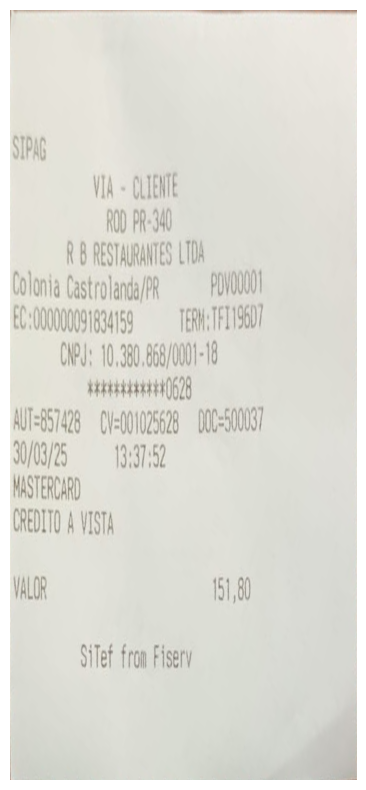

In [ ]:
mostrar(transform)

# OCR com Tesseract

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
import pytesseract

In [ ]:
!mkdir tessdata
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/master/por.traineddata?raw=true

In [ ]:
config_tesseract = "--tessdata-dir tessdata"
texto = pytesseract.image_to_string(transform, lang="por", config=config_tesseract)
print(texto)

SDB COMERCIO DE ALIMENTOS LTDA
FORT ATACADISTA
AVENIDA: ALMIRANTE JACEGUAY N.2951
COSTA E SILVA JOINUILLE SC CEP:89220-055
CNPJ: 09.477.652/0097-38
7 SRAm 260.227.978

2570972027 T0:08:55" Gnrzggvgãzgsà““““'** ***** CO0T0001142A3

NÃO É DOCUMENTO FISCAL
COMPROUANTE CREDITO OU

DÉBIT

Cartão Debito
COO do documento vinculado: 000114242
Valor total da operação R$ 55l
Valor do pagamento R$ BTAA
Quantidade de Parcelas:
Núnmnero desta parcela 1

PARTICIFE DA PROMOCAO ROTA PREMIADA DO FORT
ATACADISTA FACA SEU CADASTRO:%% CODIGO DA
PROMOCAO &%

COOFHUWMXUZIJEZIV

Cadastre no site:
uuu.fortatacadista.con.br/rotapreniada e concorra.
Loja 405 Caixa: 10 0p:900167643
Oper. 900167643
LOJA - 405

 



In [ ]:
maior = cv2.resize(transform, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)
texto = pytesseract.image_to_string(maior, lang="por", config=config_tesseract)
print(texto)

SDB COMERCIO DE ALIMENTOS LTDA
FORT ATACADISTA
AVENIDA: ALMIRANTE JACEGUAY N.2951

COSTA E SILVA JOINVILLE SC CEP:89220-055

CNPJ: 09.477.652/0097-38
al o ES RAA 11

zmmnw1mm&s*wqªªg?r“ TU0 000114283
NÃO É DOCUMENTO FISCAL

COMPROVANTE CRÉDITO OU

DÉEÉBITO

Cartão Debito
C0OO0 do documento vincutado: 000114242
Valor total da operação R$ BT
Valor do pagamento R$ B1A
Quantidade de Parcelas: 1
Número desta parcela 1

PARTICIPE DA PROMOCAO ROTA PREMIADA DO FORT
ATACADISTA FACA SEU CADASTRO:&%&% CODIGO DA
PROMOCÃAO h%

COOFHUWMXUZIJEZIMV

Cadastre no site:
uuuw.fortatacadista.con.br/rotaprenmniada e concorra.
Loja 405 Caixa: 10 0p:900167643
Oper. 900167643
LOJA - 405



# Melhoria na qualidade da imagem

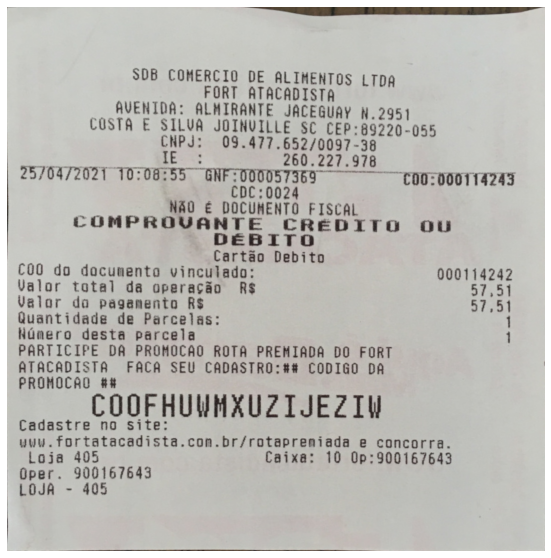

In [ ]:
mostrar(transform)

In [ ]:
transform.shape

(1061, 1049, 3)

## Aumentando o contraste e brilho

In [ ]:
brilho = 50
contraste = 80
ajustes = np.int16(transform)
ajustes.shape

(1061, 1049, 3)

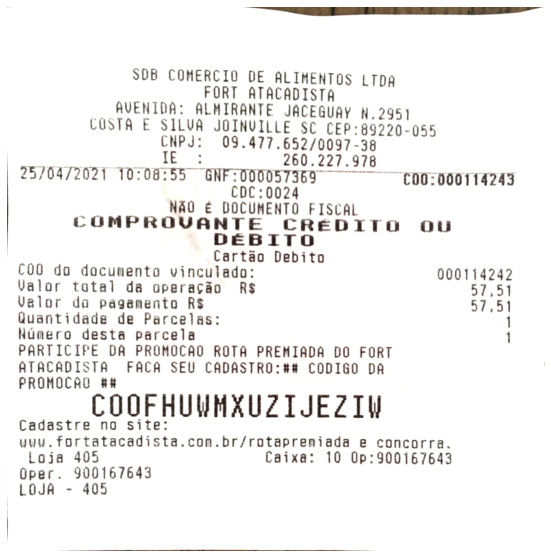

In [ ]:
ajustes = ajustes * (contraste / 127 + 1) - contraste + brilho
ajustes = np.clip(ajustes, 0, 255)
ajustes = np.uint8(ajustes)
mostrar(ajustes)

## Limiarização Adaptativa

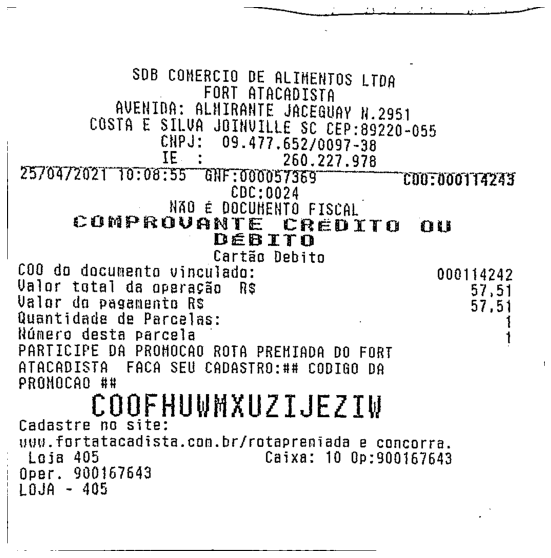

In [ ]:
img_process = cv2.cvtColor(transform, cv2.COLOR_BGR2GRAY)
img_process = cv2.adaptiveThreshold(img_process, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
mostrar(img_process)

## Remoção de bordas

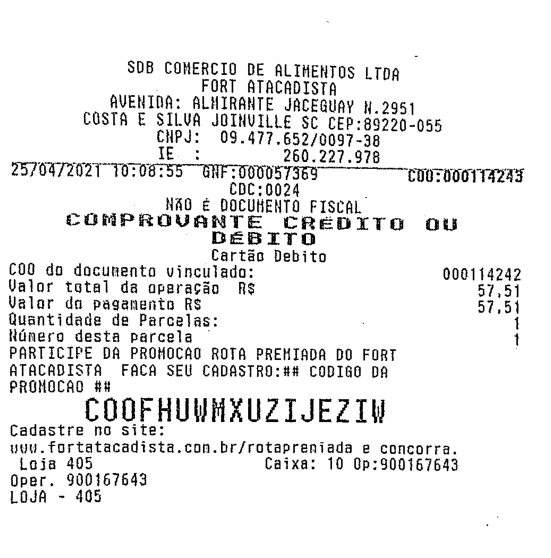

In [ ]:
margem = 18
img_final = img_process[margem:H - margem, margem:W - margem]
mostrar(img_final)

## Comparativo

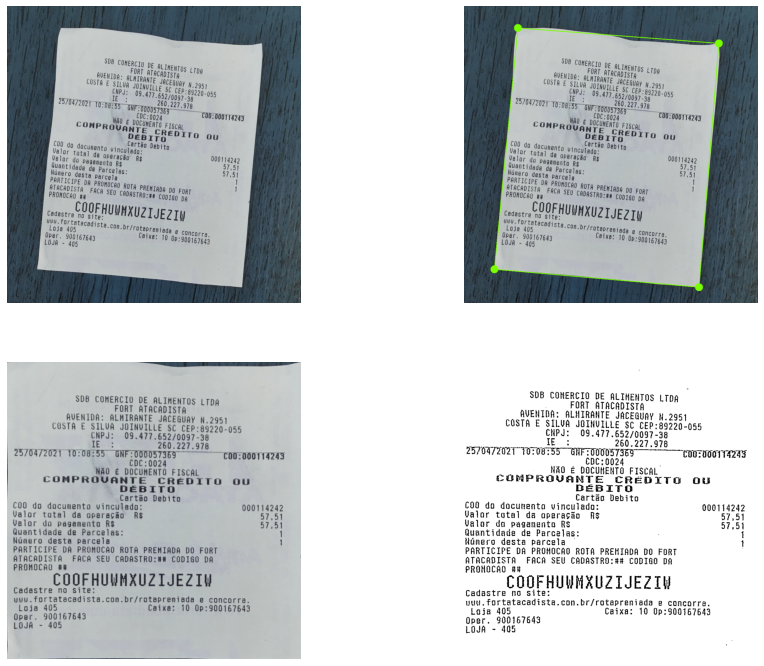

In [ ]:
fig, im = plt.subplots(2, 2, figsize=(15,12))
for x in range(2):
  for y in range(2):
    im[x][y].axis('off')

im[0][0].imshow(original)
im[0][1].imshow(img)
im[1][0].imshow(transform, cmap='gray')
im[1][1].imshow(img_final, cmap='gray')
plt.show()

# Unindo as funções

In [ ]:
def transform_imagem(nome_imagem):
  img = cv2.imread(nome_imagem)
  original = img.copy()
  mostrar(img)
  (H, W) = img.shape[:2]

  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray, (7, 7), 0)
  edged = cv2.Canny(blur, 60, 160)
  mostrar(edged)
  conts = encontrar_contornos(edged.copy())
  for c in conts:
    peri = cv2.arcLength(c, True)
    aprox = cv2.approxPolyDP(c, 0.02 * peri, True)

    if len(aprox) == 4:
      maior = aprox
      break

  cv2.drawContours(img, maior, -1, (120, 255, 0), 28)
  cv2.drawContours(img, [maior], -1, (120, 255, 0), 2)
  mostrar(img)

  pontosMaior = ordenar_pontos(maior)
  pts1 = np.float32(pontosMaior)
  pts2 = np.float32([[0, 0], [W, 0], [W, H], [0, H]])

  matriz = cv2.getPerspectiveTransform(pts1, pts2)
  transform = cv2.warpPerspective(original, matriz, (W, H))

  mostrar(transform)
  return transform

In [ ]:
def processamento_img(img):
  img_process = cv2.resize(img, None, fx=1.6, fy=1.6, interpolation=cv2.INTER_CUBIC)
  img_process = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_process = cv2.adaptiveThreshold(img_process, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9)
  return img_process

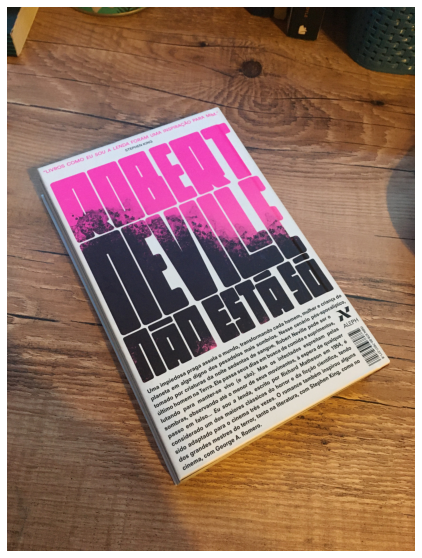

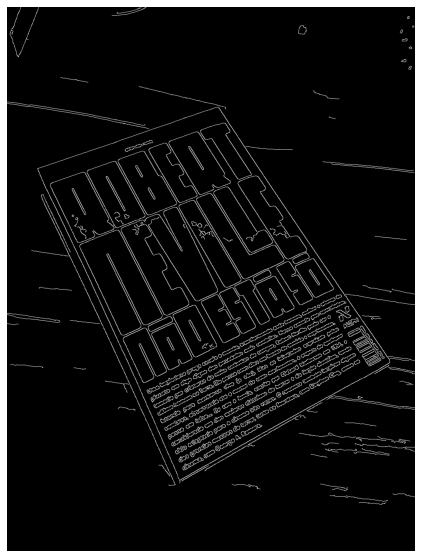

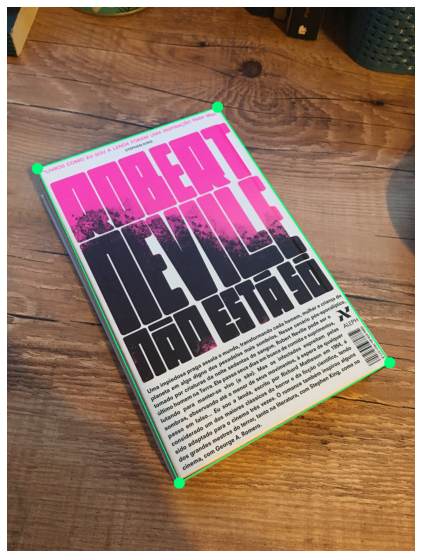

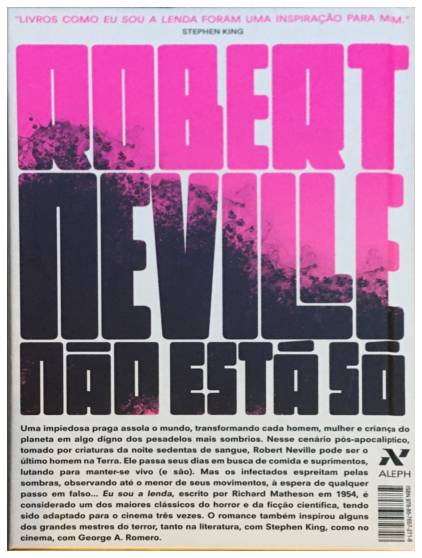

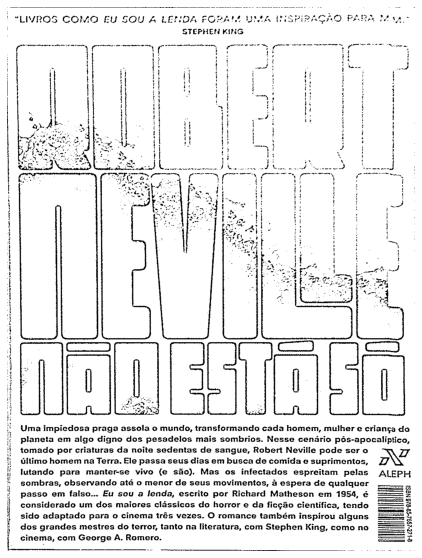

In [ ]:
img = transform_imagem('/content/imagens/livro_esal.jpg')
img_final = processamento_img(img)
mostrar(img_final)

In [ ]:
texto = pytesseract.image_to_string(img_final, lang="por", config=config_tesseract)
print(texto)

"LIVROS COMO EU SOU & LENDA FGZA UNA
STEPHEN KING

   

PAÇÃO PARA Mic

 

  

Uma impiedosa praga assola o mundo, transformando cada homem, mulher e criança do
planeta em algo digno dos pesadelos mais sombrios. Nesse cenário pós-apocalíptico,
tomado por criaturas da noite sedentas de sangue, Robert Neville pode ser o 7
último homem na Terra. Ele passa seus dias em busca de comida e suprimentos, A
lutando para manter-se vivo (e são). Mas os infectados espreitam pelas ALEPH
sombras, observando até o menor de seus movimentos, à espera de qualquer
passo em falso... Eu sou a lenda, escrito por Richard Matheson em 1954, é
considerado um dos maiores clássicos do horror e da ficção científica, tendo
sido adaptado para o cinema três vezes. O romance também inspirou alguns
dos grandes mestres do terror, tanto na literatura, com Stephen King, como no
cinema, com George À. Romero.

- 69LS8 91 NES:

 

